# Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load and process data

In [4]:
# Load the data from the files
training_data = np.load('training/training_data.npy')
valid_periods = np.load('training/valid_periods.npy')
categories = np.load('training/categories.npy')

training_data.shape, valid_periods.shape, categories.shape

((48000, 2776), (48000, 2), (48000,))

In [5]:
# Convert training_data and categories to DataFrame
data_df = pd.DataFrame(training_data, columns=[f'Timestep_{i+1}' for i in range(training_data.shape[1])])
categories_df = pd.DataFrame(categories, columns=['Category'])

# Concatenate DataFrames along the columns
df = pd.concat([data_df, categories_df], axis=1)

# Display the resulting DataFrame
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Columns: 2777 entries, Timestep_1 to Category
dtypes: float64(2776), object(1)
memory usage: 1017.0+ MB


,Timestep_1,Timestep_2,Timestep_3,Timestep_4,Timestep_5,Timestep_6,Timestep_7,Timestep_8,Timestep_9,Timestep_10,...,Timestep_2767,Timestep_2768,Timestep_2769,Timestep_2770,Timestep_2771,Timestep_2772,Timestep_2773,Timestep_2774,Timestep_2775,Timestep_2776
count,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,...,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000,48000.000000
mean,0.000004,0.000004,0.000004,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.515814,0.520281,0.528503,0.533299,0.530825,0.525855,0.522132,0.523433,0.530226,0.531927
std,0.000837,0.000813,0.000781,0.000760,0.000757,0.000749,0.000745,0.000741,0.000741,0.000733,...,0.288777,0.289387,0.287716,0.288655,0.289785,0.291925,0.296271,0.302170,0.303567,0.304784
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.260870,0.265976,0.275296,0.276525,0.269440,0.259259,0.246887,0.242881,0.246772,0.244700
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.529901,0.535941,0.546886,0.556100,0.552312,0.544393,0.542242,0.550017,0.561833,0.564695
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.774056,0.781060,0.788449,0.795617,0.794872,0.793385,0.794734,0.802337,0.809368,0.815334
max,0.183319,0.178061,0.171051,0.166542,0.165793,0.164041,0.163324,0.162288,0.162288,0.160536,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


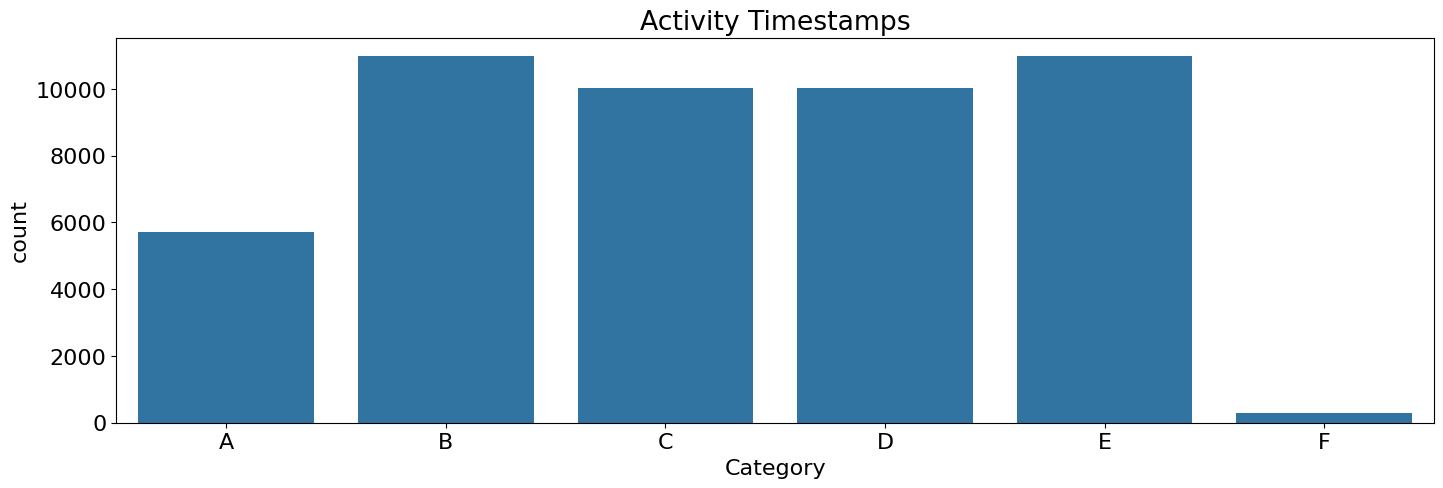

In [6]:
# Inspect activities timestamps
plt.figure(figsize=(17,5))
sns.countplot(x = 'Category', data = df, order = sorted(df['Category'].unique()))
plt.title('Activity Timestamps')
plt.show()

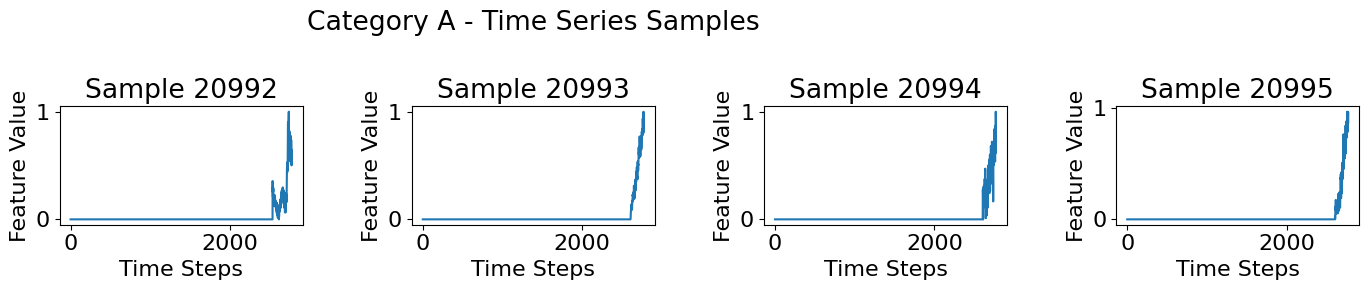

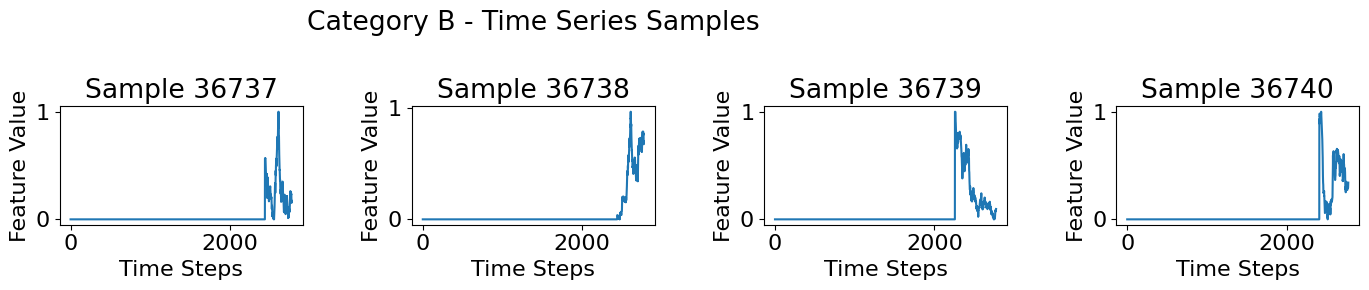

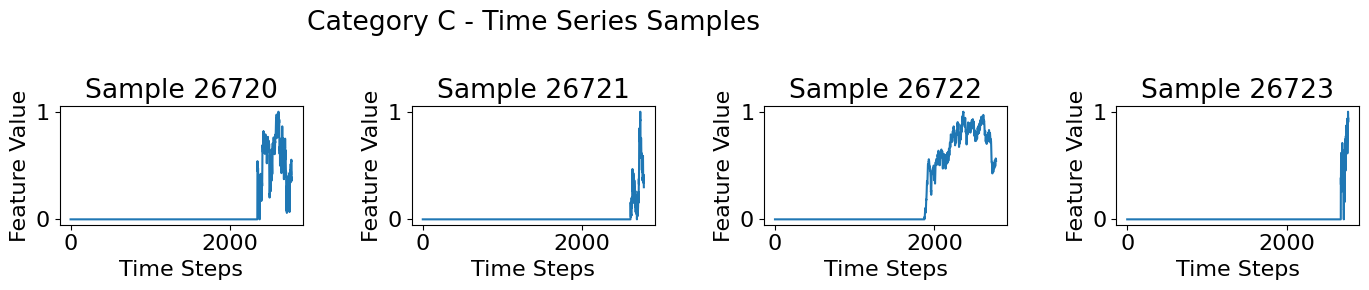

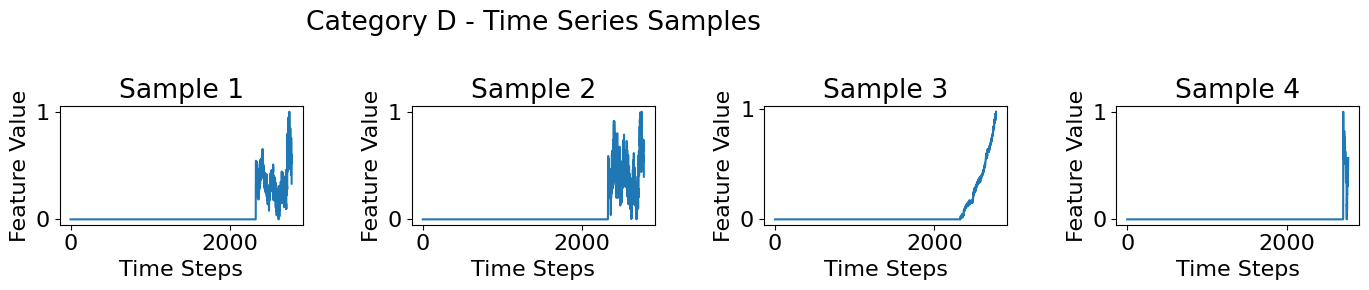

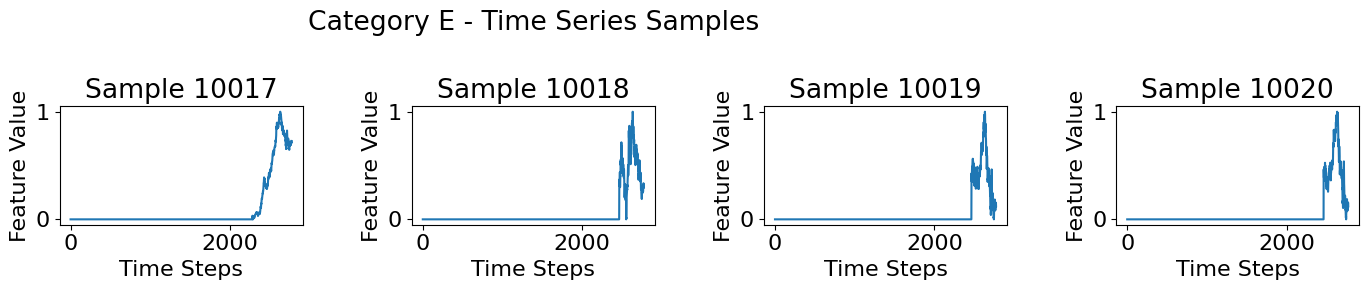

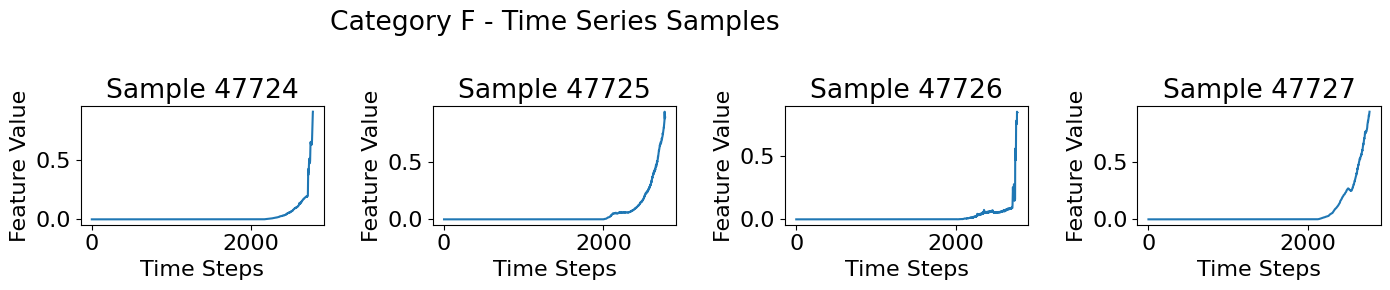

In [7]:
# Plot some samples
for category in "ABCDEF":
    to_be_inspected = 4

    plt.figure(figsize=(17, 3))  # Adjust the figure size as needed
    plt.suptitle(f'Category {category} - Time Series Samples')

    for idx in range(len(training_data)):
        if to_be_inspected == 0:
            break

        if categories[idx] != category:
            continue

        plt.subplot(1, 5, 6 - to_be_inspected)  # 1 row, 5 columns, and the current plot position
        plt.plot(training_data[idx])
        plt.title(f'Sample {idx + 1}')
        plt.xlabel('Time Steps')
        plt.ylabel('Feature Value')

        to_be_inspected -= 1

    plt.tight_layout()  # Adjust layout for better appearance
    plt.show()


## Split, Encode and Normalize

In [8]:
features = df.drop('Category', axis=1)
target = df['Category']

X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, target, test_size=0.2, stratify=target, random_state=42)

# Display the shapes of the resulting sets
print("Training set shape:", X_train_raw.shape, y_train.shape)
print("Testing set shape:", X_test_raw.shape, y_test.shape)

Training set shape: (38400, 2776) (38400,)
Testing set shape: (9600, 2776) (9600,)


In [ ]:
# Choose a time series (e.g., the first one)
time_series_index = 0

# Get valid periods for the selected time series
start_index, end_index = valid_periods[time_series_index]

# Extract the time series without padding
original_time_series = training_data[time_series_index, start_index:end_index]

# Choose the desired future length
future_length = 200  # Adjust this according to your needs

# Pad the time series to the future length
padded_future_time_series = np.pad(original_time_series, (0, future_length), 'constant')

In [9]:
print(X_train_raw.shape, X_test_raw.shape)

# Normalize both features and labels
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train = (X_train_raw-X_min)/(X_max-X_min)
X_test = (X_test_raw-X_min)/(X_max-X_min)

# the test part is also important so it might be a good idea to retrain the model including the test set, after having assessed that the model behaves properly

(38400, 2776) (9600, 2776)


In [10]:
window = 100
stride = 5

In [12]:
future = training_data[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

ValueError: Length of values (100) does not match length of index (2776)

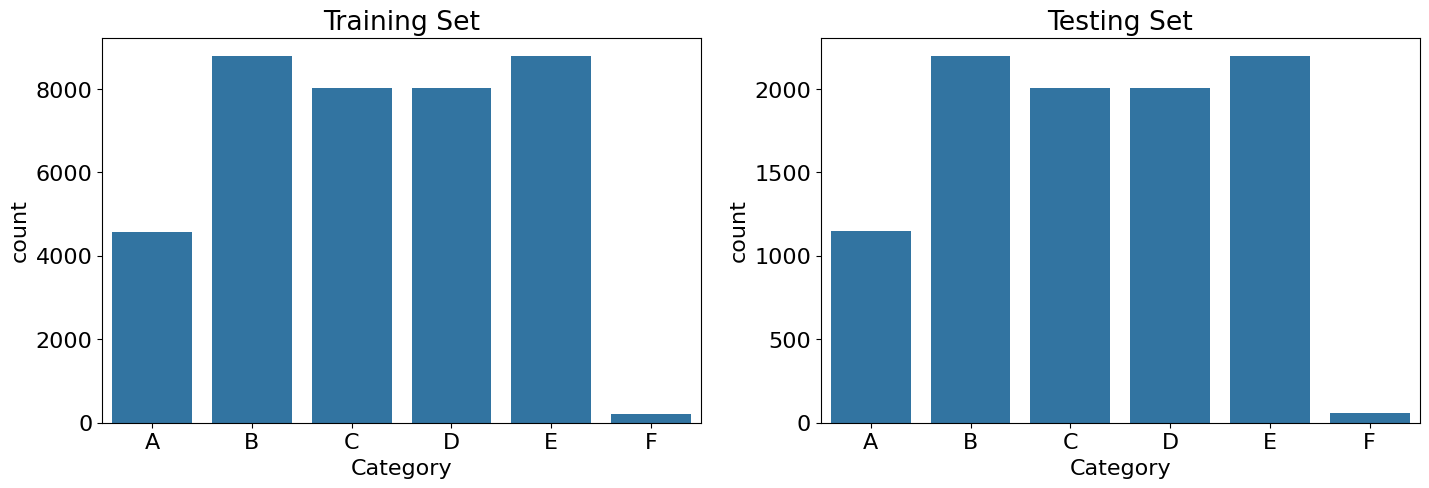

In [10]:
# Plot for training set
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, and the first plot
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title('Training Set')

# Plot for testing set
plt.subplot(1, 2, 2)  # 1 row, 2 columns, and the second plot
sns.countplot(x=y_test, order=sorted(y_test.unique()))
plt.title('Testing Set')

plt.show()

In [11]:
# Map categories to integers
category_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

y_train = y_train.map(category_mapping)
y_test = y_test.map(category_mapping)

Have you thought about further normalising your time series? In the end, they are only scaled between 0 and 1. Speaking of which, ever heard of robust scalers? (PS: remember to de-normalise in the prediction function).

In [12]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights using 'balanced' mode
class_labels = np.unique(categories)
class_weights = compute_class_weight('balanced', classes=class_labels, y=categories)

# Print or use the computed class weights
print("Class Weights:", class_weights)

Class Weights: [ 1.39664804  0.72813325  0.79864231  0.79872204  0.72892938 28.88086643]


In [13]:
from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
from tensorflow.keras.utils import to_categorical

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

y_train = to_categorical(y_train, num_classes=forecasting_period_phase1)
y_test = to_categorical(y_test, num_classes=forecasting_period_phase1)

# Build and train models

In [15]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
epochs = 200

forecasting_period_phase1 = 9
forecasting_period_phase2 = 18

input_shape, classes, X_train.shape

((2776,), 9, (38400, 2776))

In [16]:
from datetime import datetime

def save_model(model, description):
    current_datetime = datetime.now()
    formatted_datetime = current_datetime.strftime("%d%m_%H%M")

    model.save('models/' + formatted_datetime + '/' + description)

# LSTM

In [20]:
from tensorflow import keras
from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Flatten, Dense, SimpleRNN, Masking, LSTM
from keras.preprocessing.sequence import pad_sequences

def build_model(max_length, num_features=6):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(max_length, 1)))  # Adjust as needed
    model.add(Dense(units=1, activation='linear'))  # Output layer for regression

    # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error', class_weight=class_weights)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


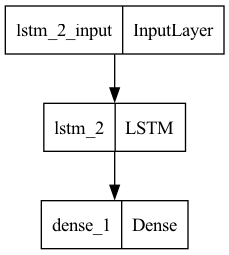

In [21]:

# Define parameter of the model
num_classes = 9
batch_size = 128
epochs = 200

max_length = max(len(seq) for seq in training_data)
padded_data = pad_sequences(training_data, dtype='float32', padding='post', truncating='post', maxlen=max_length)

model = build_model(max_length)

# Display the model summary
model.summary()

# Plot the model
tfk.utils.plot_model(model)


In [22]:
X_train.shape, X_test.shape

((38400, 2776), (9600, 2776))

In [23]:
# Train the model

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_test, y_test),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/ANN/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential' (type Sequential).
    
    Input 0 of layer "simple_rnn_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (128, 2776)
    
    Call arguments received by layer 'sequential' (type Sequential):
      • inputs=tf.Tensor(shape=(128, 2776), dtype=float32)
      • training=True
      • mask=None


If you want to give a more robust interpretation of the results, given the individual normalisation of the series, you can consider the Mean Absolute Error (MAE) as the average percentage error (scaled between 0 and 1) obtained on the predicted points compared to the ground truth.

In [19]:
save_model(model, 'resnetplusconv1d')

In [5]:
model = tfk.models.load_model('models/1812_2339/resnetplusconv1d')

# Plot results

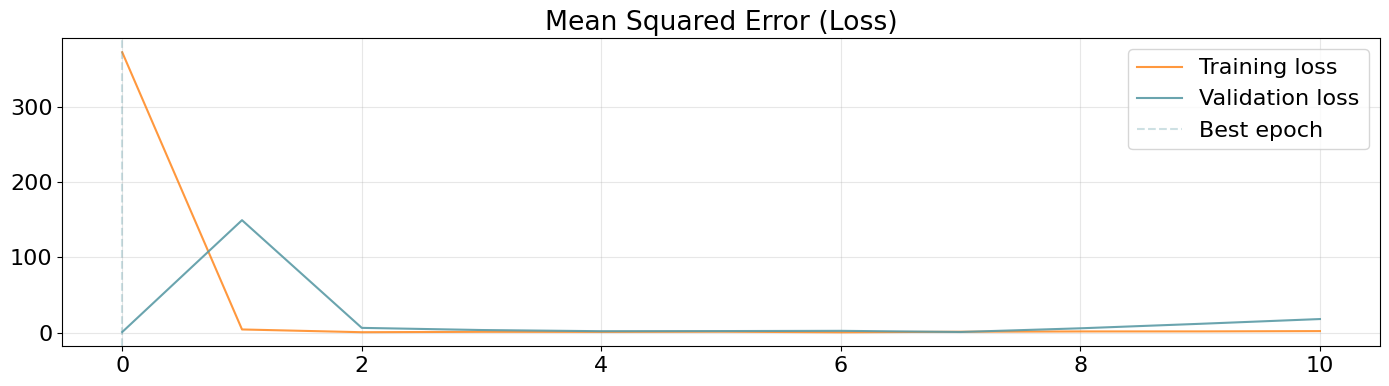

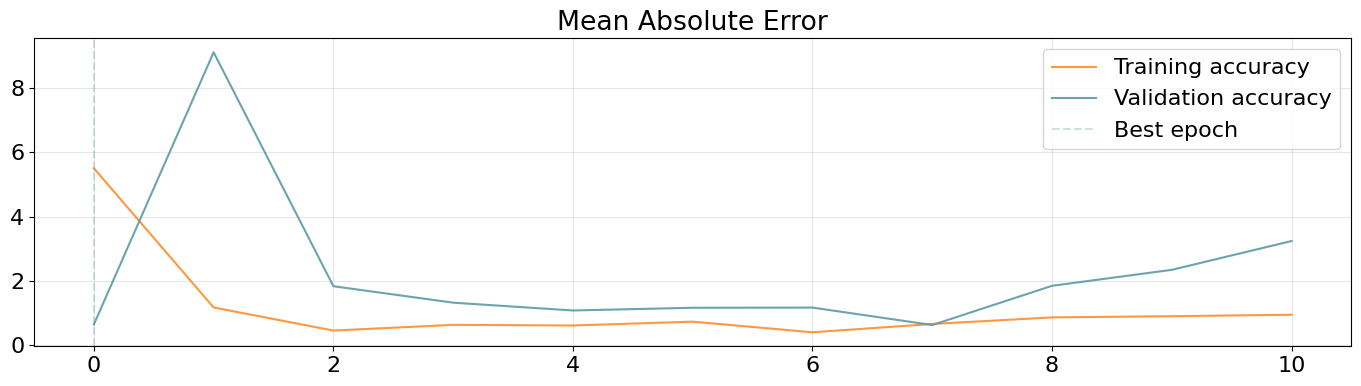

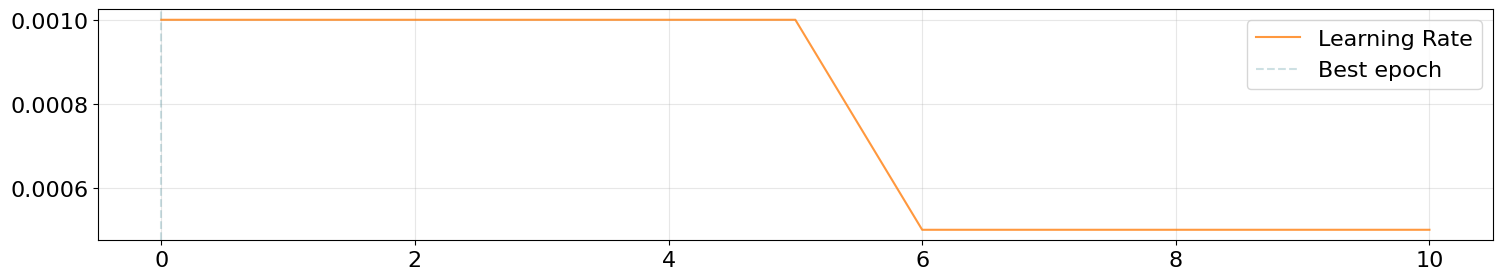

In [22]:
# Plot results

best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [23]:
# Predict the test set 
predictions = model.predict(X_test)
print(predictions.shape)

mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

300/300 [==============================] - 12s 35ms/step
(9600, 9)


(<tf.Tensor: shape=(), dtype=float32, numpy=0.65394455>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6457763>)

In [24]:
predictions.shape

(9600, 9)

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green') 
        # le linee verdi hanno dei segmenti che sono sovrascitti, poiché i samples in X_test sono sovrappost (visto che stride != window)
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()
    
# DOESN'T END EXECUTION
# inspect_multivariate_prediction(X_test, y_test, predictions, categories, forecasting_period_phase1)

In [6]:
# Compute the confusion matrix

cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

cm = cm /cm.astype(float).sum(axis=1)

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', annot=True, annot_kws={'fontsize':9,'alpha':0.6})#, xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

NameError: name 'y_test' is not defined

# Save the model

In [13]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "models/SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf
import numpy as np
import joblib
from scipy.special import softmax

class model:
    def __init__(self, path):
        # Load the models
        self.loaded_encoder = tf.keras.models.load_model(os.path.join(path, 'encoder_model.h5'))
        self.loaded_kmeans = joblib.load(os.path.join(path, 'kmeans_model.pkl'))

    def predict(self, X, categories):
        num_zeros_to_add = 2776 - X.shape[1]
        X_padded = np.pad(X, ((0, 0), (num_zeros_to_add, 0)), mode='constant')


        # Process new data (X is your new dataset)
        # Make sure to preprocess X as you did with the training data
        encoded_X = self.loaded_encoder.predict(X_padded)

        # Calculate distances to cluster centroids
        distances = self.loaded_kmeans.transform(encoded_X)

        # Convert distances to probabilities
        # The shape of probabilities will be (len(X), 9)
        probabilities = softmax(-distances, axis=1)

        return probabilities
""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)

models/SubmissionModel/fingerprint.pb
models/SubmissionModel/keras_metadata.pb
models/SubmissionModel/saved_model.pb
models/SubmissionModel/variables/variables.data-00000-of-00001
models/SubmissionModel/variables/variables.index
models/SubmissionModel/SubmissionModel/fingerprint.pb
models/SubmissionModel/SubmissionModel/keras_metadata.pb
models/SubmissionModel/SubmissionModel/saved_model.pb
models/SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
models/SubmissionModel/SubmissionModel/variables/variables.index
models/SubmissionModel_20231219_000015.zip
